# Endometrial Proteomics Power Analysis

In [37]:
import pandas as pd
import numpy as np
import scipy.stats
import collections
import re
import gseapy as gp
from gseapy.plot import barplot, dotplot
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.algorithms as al


en = cptac.Endometrial()

Checking that index is up-to-date...Loading acetylproteomics data...Loading clinical data...Loading CNA data...Loading definitions data...Loading miRNA data...Loading phosphoproteomics_gene data...Loading phosphoproteomics_site data...Loading proteomics data...Loading somatic_binary data...Loading somatic data...Loading transcriptomics_circular data...Loading transcriptomics_linear data...Formatting dataframes...

### Get Proteomics Data

In [2]:
proteomics = en.get_proteomics()

### Append Clinical Data, Select Histologic Type

In [4]:
all_genes = list(proteomics.columns)
clin_df = en.join_metadata_to_omics(metadata_df_name="clinical", omics_df_name="proteomics", metadata_cols=["Histologic_type"])
clin_df.head()

,Histologic_type,A1BG_proteomics,A2M_proteomics,A2ML1_proteomics,A4GALT_proteomics,AAAS_proteomics,AACS_proteomics,AADAT_proteomics,AAED1_proteomics,AAGAB_proteomics,...,ZSWIM8_proteomics,ZSWIM9_proteomics,ZW10_proteomics,ZWILCH_proteomics,ZWINT_proteomics,ZXDC_proteomics,ZYG11B_proteomics,ZYX_proteomics,ZZEF1_proteomics,ZZZ3_proteomics
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,Endometrioid,-1.180,-0.8630,-0.802,0.222,0.2560,0.6650,1.2800,-0.3390,0.412,...,-0.08770,NaN,0.0229,0.1090,NaN,-0.332,-0.43300,-1.020,-0.1230,-0.0859
S002,Endometrioid,-0.685,-1.0700,-0.684,0.984,0.1350,0.3340,1.3000,0.1390,1.330,...,-0.03560,NaN,0.3630,1.0700,0.737,-0.564,-0.00461,-1.130,-0.0757,-0.4730
S003,Endometrioid,-0.528,-1.3200,0.435,NaN,-0.2400,1.0400,-0.0213,-0.0479,0.419,...,0.00112,-0.1450,0.0105,-0.1160,NaN,0.151,-0.07400,-0.540,0.3200,-0.4190
S005,Endometrioid,-1.670,-1.1900,-0.443,0.243,-0.0993,0.7570,0.7400,-0.9290,0.229,...,0.07250,-0.0552,-0.0714,0.0933,0.156,-0.398,-0.07520,-0.797,-0.0301,-0.4670
S006,Serous,-0.374,-0.0206,-0.537,0.311,0.3750,0.0131,-1.1000,NaN,0.565,...,-0.17600,NaN,-1.2200,-0.5620,0.937,-0.646,0.20700,-1.850,-0.1760,0.0513


### Select only 'Endometrioid' Histologic Type

In [17]:
endometrioid_df = clin_df.loc[clin_df['Histologic_type'] == 'Endometrioid']

print(len(endometrioid_df))

endometrioid_df = endometrioid_df.drop("Histologic_type", axis = 1)

endometrioid_df = endometrioid_df.loc[:,~endometrioid_df.columns.duplicated()]


83


### Calculate and store, in a dictionary, the variance for each protein

In [18]:
variance_dict = {}
for protein in endometrioid_df:
    prot_vals = endometrioid_df[protein].dropna()
    variance = np.var(prot_vals)
    print(variance, "\n")
    if protein not in variance_dict.keys():
        variance_dict[protein] = variance
    else:
        print("REPEAT VAL")

0.34075943433299455 

0.48049778097671647 

1.5386005044173394 

0.5152592239102392 

0.05509122903636611 

0.29609425130915956 

0.3192562878713346 

0.21029103914608804 

0.13616536728962111 

0.08834805155166206 

0.22184422348013236 

0.12428801740185803 

0.06227151943977097 

0.0707222749600813 

0.09273350646392077 

0.1933952229257948 

0.04756001430631442 

0.4632990134686311 

0.11678220727545367 

0.5299769976251997 

0.4742329560372743 

0.42242125614794573 

0.23171403681858038 

0.29240627396812313 

0.3810366236115257 

0.29532258067063444 

0.34047342559503563 

0.29440822199559447 

0.581099769354536 

0.5446911832515605 

0.3743269135550588 

0.8802706239478002 

0.3173183816170707 

0.04412931717262855 

0.05757612286335288 

0.05803808789133401 

0.04176513827785695 

0.5890821354492377 

0.15728295505588616 

0.3324020732558934 

0.39166854497903925 

0.17342058678395794 

0.23113939533607675 

0.24730415392094646 

0.28531352423849066 

0.32103249081712887 

0.205

0.3073841866003461 

0.2869254186027069 

0.22638969295308467 

0.19874584261936423 

0.11206628204081633 

0.11896489928221803 

0.23946992667154338 

0.48653996340542893 

1.0043941265786036 

2.639760693458296 

0.10329599505723404 

0.032622865717520676 

0.04267796328651475 

0.46722084828564664 

0.26574644883997667 

0.28637897998263895 

0.19168014133781397 

0.05505578355157817 

0.14262386788982434 

0.03927213928204385 

0.0306987950841051 

0.3824366993438817 

0.13423031140609668 

0.36707885666424 

0.2374348888888889 

0.6985158650661628 

0.38668054009142117 

0.2500122876089506 

0.6340508667237628 

0.3823906353385398 

0.1780418576754826 

0.04004735779065178 

0.08341586049876727 

0.17738050919261186 

0.0407867471800659 

0.11057516095610395 

0.11250614218214545 

0.14668207849705325 

0.07370095795741034 

0.23354432205483042 

0.07045969945684427 

0.19143457102505446 

0.09849112970328035 

0.0466604627955291 

1.199220089222222 

0.7175631188806211 

0.123048

0.11016652839567426 

0.08108828045910876 

0.5838638279111626 

0.43491227673453325 

0.3691679944056902 

0.158302354802758 

0.06923991495116852 

0.18422608708982438 

0.2338277961038177 

0.5760458037273044 

0.15465703776027176 

1.6954830424987657 

0.38170522532968504 

0.19012053670046739 

0.14365585192646244 

0.6009694191638844 

0.6212922834467121 

0.6570562512098996 

0.960104237556 

0.6001882430193062 

0.14284478873090437 

0.704921860795442 

0.5816068272775731 

0.5344055833763971 

0.4356428354552467 

0.6420561837158862 

0.584729257254783 

0.48920661341207705 

0.3380878517109723 

0.14587319793920742 

0.1482154577360514 

0.17177656886767306 

0.22254713819076496 

1.0651812817545658 

0.3442131091769488 

0.8938388726561473 

0.4981856339838873 

0.34395627978054877 

0.2573359781964628 

0.1357376047815357 

0.51741420896432 

0.6574118909390623 

0.6115267733197853 

0.4987286178713024 

0.15438935731528525 

0.17050878052858182 

0.19340446551708523 

0.20

1.0732076042283951 

0.1535193679042476 

0.4390248489986841 

0.6441743417746842 

0.15687321759184208 

0.18691189340621278 

0.30940524665344166 

0.11962297703832192 

0.09683724563088979 

1.6782461464802614 

1.118231278194034 

0.6346491595429237 

0.34976003062981575 

0.36169787197224557 

0.36954452217157785 

1.4881353890447677 

0.4812882239256495 

0.47884388073214285 

0.650674908537093 

0.4823163194809271 

0.23559865695604587 

0.2930281311685296 

0.25556758618751624 

0.3254964451617362 

0.2124184549092044 

0.2580580671175497 

0.18460322504975546 

0.12377893394478456 

0.31637449438580245 

0.28823506598948045 

0.37721609148721147 

0.09802027563178979 

0.2209662165063488 

0.041171634753084635 

1.4142459848437496 

0.19909649587568173 

0.04730934072024969 

0.28385439999999995 

0.6042283384090908 

0.15473181987611187 

0.10395069321527069 

0.24130649662395118 

0.6214971012367545 

0.6111862834025259 

0.08406012883997675 

0.3133012520769776 

0.70301509

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




0.14212835968952972 

0.09385859545819744 

0.3252894270816116 

0.1432676059092246 

0.06604712015571375 

0.274884483836347 

0.04173397069243722 

0.04646135951490319 

0.24795546614681388 

0.04802623619767747 

0.22315413359999997 

0.05473118241715778 

0.07494032605976687 

0.24987556786759196 

0.4575223211862346 

0.4341504415648136 

0.23947388501531877 

0.26141251146578603 

0.05209243445727974 

0.28863217787127304 

0.4698389259253885 

0.29819153524816 

0.10903082711538459 

0.10919880509724487 

0.3219537643681442 

0.23785136023199296 

1.0500738992364642 

0.34985459115558454 

0.09221119287034402 

0.060927482445928584 

0.138109097082342 

0.5046705141799344 

2.8095734387819733 

0.645693856323731 

3.4007776523994773 

1.0645625296096386 

0.207067823760749 

0.14110784549188563 

0.4935230011785177 

0.09674462646895055 

0.1569120381902448 

1.6573257577590959 

0.0530832960537378 

0.3690679855099144 

0.17127689676205543 

0.1550683169276528 

0.794136367987

0.04439912686860242 

0.09847325001758862 

0.050236225903904794 

0.03985826278499056 

0.5590954055508783 

0.26859415941936426 

0.07418760502043839 

0.49648092985629266 

0.4039839988828858 

0.4612439843097956 

0.1786642432205093 

3.2483417521778435 

1.659158577883031 

0.2867844367307937 

0.49158678099843744 

0.14957090539117446 

0.6828300535122369 

0.21467098095663267 

0.059587677214544936 

0.15677307630062437 

0.11528666488180551 

0.44186760035123973 

0.40496680947368424 

0.3586167424527736 

0.37908781901427324 

0.024355975144694435 

0.30329214411375177 

0.3514204320359374 

0.23664548364639285 

0.6014377476922338 

0.22909843599994179 

0.14664227905510202 

0.3043055041850684 

0.8395567042681377 

0.2380343776737698 

0.26833091174123963 

1.3046629055421683 

0.44030476838845156 

0.5425811355274783 

0.08318778941791262 

0.06363549785109594 

0.3157409648766716 

0.16669027737903905 

0.7828272670631151 



0.98811041124375 

0.1073348977674554 

0.2675

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)





0.27945339639166655 

0.4201239130540969 

0.5583898865742909 

0.07492743894022354 

0.06784052638702279 

0.2785000025556104 

0.6001942694469444 

0.1715907011448976 

0.09212861312399481 

0.05703013095143242 

0.05905062281001711 

0.04386459168360459 

0.21404739487436045 

0.05885889920685153 

0.04709109734902017 

0.0886006673914356 

0.1000150502709827 

0.029151730348816934 

0.031367808953077364 

0.3311636785934969 

0.07981533619861622 

0.06029023955592976 

0.09368502125812164 

0.11281432777215245 

0.07073049443448977 

0.07451843844049237 

0.0806498421451601 

0.06196691747892467 

0.06630225463687037 
 

0.0718595198222038 

0.11859598042967048 

0.0424734800094063 

0.03879607437680361 

1.0786001346366785 

0.2544774428663377 

0.3936274710663495 

0.1598927687472782 

0.8437510896153289 

0.5913851269963978 

0.20754933757736427 

0.1439697301538086 

0.3289903633655217 

0.24125276524843745 

0.2938496640830449 

0.21621376107417623 

0.2643131268750001 

0.5

0.23517180159763315 

0.08009600320095805 

0.2944545196235156 

0.13952674343515753 

0.1246983946548992 

0.8679471458024692 

0.6589476144750473 

0.2074739957344671 

0.14090552068515022 

0.0822667421948033 

0.25761287259108734 

0.32766587326929886 

0.19004884662222224 

0.2229555100397445 

0.29377464223649297 

0.9287910058433937 

0.8788248177986643 

1.696629479039047 

0.35695471893899483 

0.1380416749898098 

0.24457238013816238 

0.45055887649647247 

0.056917470795442010.06767573121521266 

0.1473829392106289 

0.3574746548596939 

0.29067095435625695 

0.048633616335694595 

0.11299681474826535 

0.11137260516008128 

0.15539410854533312 

0.04966349138417766 

0.13152886076803602 

0.0790142431018197 

0.22762473876923683 

0.9436696476402369 

0.7885391102105092 

0.7432945758617215 

0.3659397556022354 

0.368124532504 

0.39771804969324903 

0.21256818673247216 

0.09555005851670778 

0.15358363817459728 

0.056782935729423716 

0.23973044512355934 

0.62598634421

0.7671366906499058 

0.3334201625708885 

0.6292742379665842 

0.23737186585132825 

0.14068401224594324 

0.043507539832138196 

0.31837238670185725 

0.06844330120624181 

0.037773574414486866 

0.8705646963085213 

0.434172588773436 

0.5050723717092769 

1.0847165224581945 

0.40523697105562495 

0.11640946141747716 

0.3456372284540572 

0.20212155971406592 

0.186129473154304 

0.16083244127666915 

0.834770568888889 

0.8798413750224707 

0.2215129079626071 

0.3086547083001888 

0.7233073129539845 

0.15670114606984126 

0.37295487615472905 

0.21360053150683694 

0.1510826275 

0.21560825129252428 

0.3215249475578399 

0.23306080045555558 

0.45445529977052423 

0.26377662048192774 

0.08625546855588448 

0.12282880905599997 

0.26448011626266354 

0.11949351093229782 

0.10765056273720425 

0.15484628008709536 

0.7431326098911308 

0.34569833180734516 

0.15563996822438667 

0.0915459880161707 

0.26090988172155605 

0.15738897589595013 

0.9543285091381285 

0.055100574797

0.052668311930991404 

0.53248571787496 

0.22780668307875424 

0.7690642638902598 

0.31744142778083906 

0.06862651688027292 

0.09490487528500001 

0.13312412175111113 

0.09636626983844132 

0.08876687526201191 

0.09760074792997532 

0.32415911375378137 

0.07937192609356947 

0.06188009099277107 

0.33917484882653065 

0.4197667076527798 

0.1367742214532872 

0.043620727909091016 

0.4091241534744269 

0.6689366304889999 

0.28662600302207375 

0.0633868725574394 

0.24011221231641738 

0.31757075860071343 

0.06072806414489766 

0.13919156391122925 

0.2982115861025315 

0.06350330194710407 

0.0829419873856673 

0.48579521731422337 

0.07186783435932644 

0.16166312666666668 

0.15510575381913194 

0.2745816370262388 

0.13162136322357382 

0.8263477581883124 

0.19861067402987376 

0.2881613915249433 

0.17278237867739976 

0.061226313894237175 

0.15754961094582703 

0.13215562034826533 

0.5012888771048613 

0.2158184619979189 

0.16983395380177516 

0.0794071778749601 

0.

0.11255852112753671 

0.05581984515867497 

0.21496778086514728 

0.11000029965187987 

0.10610169908113594 

0.9466451334180289 

0.3096735434576862 

0.09966630525603139 

0.08868820307806533 

0.14167847729043404 

0.1758017273641747 

0.07582040881773842 

0.46149169980256244 

0.18919936754010744 

0.14738276299976766 

0.5434856769777907 

0.11643538217738426 

0.27890468265120766 

0.42531293047527624 

0.7758176353720184 

0.650553740264654 

0.226292821066695 

0.0929498886731093 

0.19900754055772976 

0.30071941512265926 

0.15718569516796663 

0.13376165075047175 

0.23645437759352594 

0.32822545110393386 

0.17006265745971832 

1.1566256773152965 

0.16294563501187398 

0.25092358489229205 

0.12612846025299368 

0.36983853787954707 

0.38246671433238494 

0.031904905271494845 

0.48667340776458146 

0.37743145270721445 

0.44268435546346374 

0.4054294028335027 

0.12630939756641052 

0.1828962279886053 

0.44202823271049596 

0.029431176839163888 

0.058422262893424316 

0.11285183560197419 

0.030967667055096234 

0.08331920707436899 

0.08236997060830314 

0.14896417810605428 

0.2737884955505588 

0.43492215235516496 

0.22370782691516275 

0.36859379780566126 

0.08166281165545071 

0.2812715910458702 

0.16234637239108726 

0.06588280315357815 

0.2486685396725207 

0.06286717047130208 

0.18174548710230803 

0.28756998761875463 

0.07610391016945856 

0.4006231842688376 

2.9408139668328817 

0.18281876320510967 

0.06550492234065904 

0.1584867483116272 

0.18211906391350874 

0.3574128009395268 

0.14048950040554506 

0.2078962324969952 

1.155380291652794 

0.19787286395472317 

0.24152730424556215 

0.2540052683385397 

0.22801514433084638 

0.14754690649264046 

0.16517445607429232 

0.045896088146452615 

0.1076856946678906 

0.2733988448773116 

0.16543197723814773 

0.13330357347946 

0.07876028699460007 

0.03029829613679779 

0.4912166638436926 

0.6857457862089994 

0.3208360005934388 

0.14974537927757298 

0.3439585746848309 

0.1550

0.5908744856205544 

0.28072256071345625 

0.03783750471226593 

0.06278352616344898 

0.16349416906386727 

0.10352050999343881 

0.12061652088401653 

0.07450396016400666 

0.15133827727587149 

0.5353534615984032 

0.06689480379654403 

0.41007750617283945 

0.09906351155325445 

0.5629271076731311 

0.10275077555555556 

0.23090525074095017 

0.5812649619306138 

0.24646151078062134 

0.08292946214277833 

0.08685418071130792 

0.20010857148079542 

0.18449776252370437 

0.05880371657700656 

0.1250745763959358 

0.4962868498743215 

0.035376457364436925 

0.1754164101349569 

0.10455072393528815 

0.1039642227214916 

0.16451046918856146 

0.2054789049846154 

0.12714795757291336 

0.2659717064479605 

0.24812278982145447 

0.1720088326248803 

0.47808304389516626 

0.3394767805080565 

0.22398992821068373 

0.15298229141163275 

0.08621553683518683 

0.07456929036446508 

0.10644631674553635 

0.4017958485759907 

0.5279318039049588 

0.2914182769203368 

0.06549099777189722 

0.

0.11149559022778341 

0.07422280316772945 

0.07508233913476559 

0.0500747459588039 

0.24035491353043723 

0.040605954405487 

0.5886894351092612 

0.11826805168947598 

0.039975141661663514 

0.6758881243665842 

0.03377641761106111 

0.1045542684298737 

0.1417129322746407 

0.10766012105966033 

0.5379684357162736 

1.0056453521655273 

0.2540604854780664 

0.17955680969722226 

0.11587627148381348 

0.06442622715746843 

0.2590561949559878 

0.09832614116127156 

0.07573453325495748 

0.094412774728756 

0.043224530585708014 

0.22051022811110457 

0.24918277280223544 

1.4567308334366087 

0.2629815291104369 

0.06711285963704457 

0.22100384601030634 

1.699754372979065 

0.23892658382612855 

1.3464674578000877 

0.29818337449792237 

0.24310591692747865 

0.6216485857221644 

1.1382894654956888 

0.10036326301381912 

0.0725742051192626 

1.0298237652585016 

0.2439335404489796 

0.05569750644645085 

0.1505467828112695 

0.13453438125794742 

0.2480617171597632 

0.400065550

0.043304288140593096 

0.07603093592066222 

0.11897736686482799 

0.24337823647928583 

0.07327754637651328 

0.16654714099467674 

1.5485087207638888 

0.05717283132335608 

0.4999103678066483 

0.13552460925671006 

0.09624113282928351 

0.25494028723588436 

0.04750841231903035 

0.05853892821068359 

0.17219222808027296 

0.16911250030805636 

0.04479629437022596 

0.05258938800743213 

0.09979962065986356 

0.13567303939976777 

0.20800560163157464 

0.138403365663928 

0.22430478658374217 

0.07403986646550181 

0.09981419067205693 

0.14831707200600955 

0.0827074540138889 

1.0033964923040002 

1.1446957265960225 

3.122616101126587 

0.38819253340795473 

0.5539378140562926 

0.721786918903063 

0.0698635123215561 

0.32721510662798664 

0.46650626367542475 

0.07575125326407316 

0.05915976318539702 

0.04286682263930905 

0.1418823883205109 

0.3318474828238234 

0.2896365310699972 

0.13136396509698098 

0.1932627914609375 

0.0805051003192626 

0.15391119593842356 

0.075

0.12753946888468806 

0.32983610452059375 

0.22746794812364637 

0.27008779834228475 

0.17862901647318918 

0.40447444733223087 

0.5175308867946291 

0.2970122540122992 

1.0065434565828402 

0.19835600904849035 

0.5195126813897791 

0.34299017758455513 

0.9636995551400787 

0.797403296635121 

0.09730662642094469 

0.3151022509120683 

0.3259858791145305 

0.5030181118782222 

0.07081750996661346 

0.4618102957903904 

0.42263582746793454 

0.08214602393065817 

0.09211169553197851 

0.061007335702162886 

0.065284070205602 

0.02161543381856822 

0.06398693354364927 

0.12942221710277865 

0.07942806467711107 

0.514904677042793 

0.0592239675 

0.41986595184291503 

0.46915692526610525 

0.8387524168552476 

0.27364457326482805 

0.1152605121951227 

0.12087461479944837 

0.6633904972286011 

0.026999272064682837 

0.35146415407797926 

0.2742151838857044 

0.6696287839553277 

0.17196226872237233 

0.11055405849788914 

0.5601595709260405 

0.16796276926140222 

0.355774970663

0.06628208102977007 

0.07815303182305852 

0.3455723437313979 

0.09470491333505589 

0.07127842705472491 

0.16024182315833943 

0.4841653327367187 

0.2970528451155325 

0.07825084091644649 

0.5459281508264463 

2.4663771800179926 

8.191257517633137 

1.2324269664888887 

0.3337904339962259 

0.438866199728193 

0.28373230279271905 

0.48915157885543986 

0.23647864212373806 

1.4963581873765612 

0.9703789625313339 

1.2839085948700824 

0.26456991529852836 

0.09829889855228842 

0.16670977141053858 

1.358711484103869 

0.3823220462939759 

0.5437380111685296 

0.24132603813017756 

0.3732894722909275 

0.151935970851 

0.889169459296917 

1.6126834195777588 

1.962574482006173 

4.286230341982798 

1.8892020338222224 

1.3894870436 

4.103606703662109 

0.31672898582805986 

0.736538021303179 

1.1943239900680274 

0.5864947073408624 

0.13856141722386411 

0.2275211445285818 

0.18520830919480794 

0.757766287236493 

0.11032099006289407 

0.705796167965133 

0.13640357280592

0.4505966068182899 

0.08760974738404453 

0.3094917867597634 

0.10487777571412399 

0.11187455051789806 

0.09398724627757293 

0.10819189248063753 

0.21842187609955 

0.3887784774258094 

0.21062433215964582 

0.10666943910291884 

0.33818740336768754 

0.7393186742067451 

0.44522624894179136 

0.11987027069261143 

0.17873059242456085 

0.19981215826193222 

0.15184707833912042 

0.5596656352012759 

0.06962413359451415 

0.06820565712727535 

0.33156297857689093 

0.23175762307446657 

0.40638000830028964 

0.3064745111944638 

0.3759718103040789 

0.6137379403483395 

0.3427144824597633 

0.5386018734486065 

0.6179818733457265 

0.2701473494307375 

0.29095724719593546 

0.46384545006241823 

0.5978253695093336 

0.3671720598101031 

0.13111614143625142 

0.601573990442735 

0.3182886357101907 

1.2195819122179121 

0.5137261072166351 

0.8123387495984031 

0.21190910308875008 

0.32205558503489634 

1.0893582050921762 

0.4765606824706053 

0.17315648607054723 

0.21009899758

0.03926070277569777 

0.027384199008768758 

0.050703185661111934 

0.170160668576 

0.08030573955526202 

0.14422515110393383 

0.04831218848591231 

0.08733476572898823 

0.03646671453856146 

0.10095820454489769 

0.11085930851518735 

0.07068173619706228 

0.09416113581387721 

0.1137076922268254 

0.09768371414065902 

0.07440405209513719 

0.042524212322103065 

0.05767832311301842 

0.06286767136225864 

0.037045786565568305 

0.07952905404186938 

0.29681318854029815 

0.12519089660749502 

0.10947644738803892 

0.07685432598345186 

0.3081590587381915 

0.34500942298395065 

0.11405189429306062 

0.08392254291471853 

0.2523154741794745 

0.09536038107417623 

0.04431255907098271 

1.0309934797060536 

0.14273810510669177 

0.09534170674507066 

0.11541379173984612 

0.29822954765661197 

0.04589197615285238 

0.07784639905646684 

0.22607105599039043 

0.052643513235012346 

0.05373666956887791 

0.3499513346225868 

0.30743543493079595 

0.07043449508019499 

0.1751304633106

0.057355358215735244 

0.14364593748442447 

0.27714759094327834 

0.04881782150816 

0.10089613536394251 

0.2790742615416665 

0.2762147147543253 

0.1685619419541038 

0.06086563047127304 

0.025481286472364355 

0.10317174074243973 

0.2210697966858282 

0.12538788540000007 

0.0624742096544175 

0.14908064361034162 

0.08909738009374366 

0.12805322533888802 

0.09744190729161001 

0.07602189297137467 

0.11378100792541733 

0.16302441464193848 

0.2149919169 

0.16801279155592977 

0.26089381306735815 

0.16577130625913114 

0.15457584251836554 

0.14441562069503078 

0.08677988143070486 

0.1779130733895164 

0.4122829757777777 

0.18839225055156145 

0.05261831157444157 

0.10231755555555555 

0.21133244576097215 

0.09081286204705882 

0.6526057706122448 

0.21309314018220346 

0.37915132927335643 

0.2224856022807889 

0.35415549181818184 

0.2517334690972855 

0.16835703091566892 

0.08432224168890447 

0.05139553035914326 

0.08176603416092322 

0.14778405868860509 

0.2253

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Print variance for each protein

In [31]:
for key, val in variance_dict.items():
    print(key, ": ", val, "\n")

A1BG_proteomics :  0.34075943433299455 

A2M_proteomics :  0.48049778097671647 

A2ML1_proteomics :  1.5386005044173394 

A4GALT_proteomics :  0.5152592239102392 

AAAS_proteomics :  0.05509122903636611 

AACS_proteomics :  0.29609425130915956 

AADAT_proteomics :  0.3192562878713346 

AAED1_proteomics :  0.21029103914608804 

AAGAB_proteomics :  0.13616536728962111 

AAK1_proteomics :  0.08834805155166206 

AAMDC_proteomics :  0.22184422348013236 

AAMP_proteomics :  0.12428801740185803 

AAR2_proteomics :  0.06227151943977097 

AARS_proteomics :  0.0707222749600813 

AARS2_proteomics :  0.09273350646392077 

AARSD1_proteomics :  0.1933952229257948 

AASDHPPT_proteomics :  0.04756001430631442 

AASS_proteomics :  0.4632990134686311 

AATF_proteomics :  0.11678220727545367 

ABAT_proteomics :  0.5299769976251997 

ABCA8_proteomics :  0.4742329560372743 

ABCB1_proteomics :  0.42242125614794573 

ABCB10_proteomics :  0.23171403681858038 

ABCB6_proteomics :  0.29240627396812313 

ABCB7_

ADGRL4_proteomics :  0.21482122805383602 

ADH1A_proteomics :  1.9521065831416662 

ADH1B_proteomics :  2.6983183184154678 

ADH1C_proteomics :  1.8006856226709242 

ADH4_proteomics :  0.5730086698194802 

ADH5_proteomics :  0.20288230716205544 

ADH6_proteomics :  1.3204180576613584 

ADH7_proteomics :  1.783332202619859 

ADHFE1_proteomics :  0.4032043936000001 

ADI1_proteomics :  0.23255272454266226 

ADIPOQ_proteomics :  1.1738869955697486 

ADIPOR1_proteomics :  0.3037776795555555 

ADIRF_proteomics :  0.9826119907957908 

ADK_proteomics :  0.1338129015577297 

ADM_proteomics :  1.207063238143962 

ADNP_proteomics :  0.0455628907224796 

ADO_proteomics :  0.09786972029748874 

ADPGK_proteomics :  0.09429553918118742 

ADPRH_proteomics :  0.2182922513439396 

ADPRHL2_proteomics :  0.07535881891676584 

ADPRM_proteomics :  0.15746326858223064 

ADRA2A_proteomics :  0.47508132441855994 

ADRM1_proteomics :  0.07637641444891859 

ADSL_proteomics :  0.12541055757584563 

ADSS_proteomi

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



:  0.053685862567048916 

ARF1_proteomics :  1.5119129485092175 

ARF3_proteomics :  2.2586718397706496 

ARF4_proteomics :  0.2545109151008991 

ARF5_proteomics :  0.1749838967529684 

ARF6_proteomics :  0.08443180256812309 

ARFGAP1_proteomics :  0.061475925024560875 

ARFGAP2_proteomics :  0.06920056140757729 

ARFGAP3_proteomics :  0.24793355430095523 

ARFGEF1_proteomics :  0.12053116896533603 

ARFGEF2_proteomics :  0.0822861290896502 

ARFGEF3_proteomics :  0.2334655795964581 

ARFIP1_proteomics :  0.11713086926987953 

ARFIP2_proteomics :  0.19651435465812161 

ARFRP1_proteomics :  0.0997848181955001 

ARG1_proteomics :  0.8694146257360137 

ARG2_proteomics :  0.6417196172695099 

ARGLU1_proteomics :  0.06188816479800708 

ARHGAP1_proteomics :  0.10011022300467413 

ARHGAP10_proteomics :  0.2800962486764698 

ARHGAP12_proteomics :  0.10348736030193059 

ARHGAP15_proteomics :  0.36297085886714353 

ARHGAP17_proteomics :  0.057829325863405445 

ARHGAP18_proteomics :  0.1887930740

ATP12A_proteomics :  1.6954830424987657 

ATP13A1_proteomics :  0.38170522532968504 

ATP13A2_proteomics :  0.19012053670046739 

ATP13A3_proteomics :  0.14365585192646244 

ATP1A1_proteomics :  0.6009694191638844 

ATP1A2_proteomics :  0.6212922834467121 

ATP1B1_proteomics :  0.6570562512098996 

ATP1B2_proteomics :  0.960104237556 

ATP1B3_proteomics :  0.6001882430193062 

ATP23_proteomics :  0.14284478873090437 

ATP2A2_proteomics :  0.704921860795442 

ATP2A3_proteomics :  0.5816068272775731 

ATP2B1_proteomics :  0.5344055833763971 

ATP2B2_proteomics :  0.4356428354552467 

ATP2B3_proteomics :  0.6420561837158862 

ATP2B4_proteomics :  0.584729257254783 

ATP2C1_proteomics :  0.48920661341207705 

ATP2C2_proteomics :  0.3380878517109723 

ATP5F1A_proteomics :  0.14587319793920742 

ATP5F1B_proteomics :  0.1482154577360514 

ATP5F1C_proteomics :  0.17177656886767306 

ATP5F1D_proteomics :  0.22254713819076496 

ATP5F1E_proteomics :  1.0651812817545658 

ATP5IF1_proteomics :  0.3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 0.2889673664550443 

CDA_proteomics :  1.1690721169272784 

CDAN1_proteomics :  0.09971203589191463 

CDC123_proteomics :  0.09054158438101323 

CDC14A_proteomics :  0.15533257601384684 

CDC16_proteomics :  0.06559346939878066 

CDC20_proteomics :  0.49991364124334786 

CDC20B_proteomics :  0.7878517867877499 

CDC23_proteomics :  0.03625737409342431 

CDC26_proteomics :  0.09117435813102044 

CDC27_proteomics :  0.046560177094295246 

CDC34_proteomics :  0.23563983060563218 

CDC37_proteomics :  0.06871687427953288 

CDC37L1_proteomics :  0.0586004264463928 

CDC40_proteomics :  0.057318265115430395 

CDC42_proteomics :  0.1786305930088652 

CDC42BPA_proteomics :  0.17566289184682826 

CDC42BPB_proteomics :  0.08071939337067788 

CDC42BPG_proteomics :  0.19716547949191474 

CDC42EP1_proteomics :  0.2701905341184208 

CDC42EP2_proteomics :  0.6081236211409494 

CDC42EP3_proteomics :  0.444064881907882 

CDC42EP4_proteomics :  0.16187860848364063 

CDC42EP5_proteomics :  0.45923835414

COL3A1_proteomics :  0.7828161486126683 

COL4A1_proteomics :  0.21133575175238897 

COL4A2_proteomics :  0.21237218534765573 

COL4A3BP_proteomics :  0.23236381642917703 

COL5A1_proteomics :  0.539214056026506 

COL5A2_proteomics :  0.8073442673956741 

COL6A1_proteomics :  1.0205678218870664 

COL6A2_proteomics :  0.714700236251996 

COL6A3_proteomics :  0.8080730831267239 

COL7A1_proteomics :  0.644985514417187 

COL9A2_proteomics :  0.6443788522212962 

COLEC11_proteomics :  0.6271349304758347 

COLEC12_proteomics :  0.43650910925501957 

COLGALT1_proteomics :  0.16220727700301957 

COLGALT2_proteomics :  0.7295735686710884 

COMMD1_proteomics :  0.062172747590351074 

COMMD10_proteomics :  0.038193708443983176 

COMMD2_proteomics :  0.05892311021598373 

COMMD3_proteomics :  0.27317603382399996 

COMMD3-BMI1_proteomics :  0.10940522317813904 

COMMD4_proteomics :  0.07242606569513718 

COMMD5_proteomics :  0.0669075588950791 

COMMD6_proteomics :  0.30176626524496475 

COMMD7_pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 

DYRK1B_proteomics :  0.15774451439257275 

DYSF_proteomics :  0.2786788461758603 

DZIP3_proteomics :  0.11696603194018411 

E2F3_proteomics :  0.13709903836440238 

E2F4_proteomics :  0.060898101796341975 

E2F5_proteomics :  0.1383908568205707 

E4F1_proteomics :  0.05677672726212803 

EAF1_proteomics :  0.20987724703124996 

EAPP_proteomics :  0.21295787803916383 

EARS2_proteomics :  0.15159109604749596 

EBAG9_proteomics :  0.25412437619599365 

EBF1_proteomics :  0.4458578538133256 

EBF3_proteomics :  0.7489535136 

EBNA1BP2_proteomics :  0.1203611154536217 

EBP_proteomics :  0.5054255893638889 

ECD_proteomics :  0.07684631590910146 

ECE1_proteomics :  0.3694732018878911 

ECH1_proteomics :  0.2833111970678183 

ECHDC1_proteomics :  0.17017726583077367 

ECHDC2_proteomics :  0.32015836242215123 

ECHDC3_proteomics :  0.7443468711834226 

ECHS1_proteomics :  0.22300576516638124 

ECI1_proteomics :  0.2873948296032225 

ECI2_proteomics :  1.0180324853580496 

ECM1_proteomics

FAM129B_proteomics :  0.1916319614044372 

FAM133B_proteomics :  0.24844827120685312 

FAM135A_proteomics :  0.22701547118716492 

FAM136A_proteomics :  0.21741755036638133 

FAM13A_proteomics :  0.20318070384066358 

FAM151B_proteomics :  0.17911738607968966 

FAM160A1_proteomics :  0.24550383485893437 

FAM160A2_proteomics :  0.0853959075477428 

FAM160B1_proteomics :  0.07404413078182705 

FAM160B2_proteomics :  0.13044711110950788 

FAM161A_proteomics :  0.6455623492218778 

FAM162A_proteomics :  0.5517226103033823 

FAM167A_proteomics :  0.8320216606881597 

FAM168A_proteomics :  0.10863011705422292 

FAM168B_proteomics :  0.16746814352399733 

FAM169A_proteomics :  0.4805489687861518 

FAM171A1_proteomics :  0.19311961494846858 

FAM171A2_proteomics :  0.3215748198347801 

FAM172A_proteomics :  0.08667017573194952 

FAM174A_proteomics :  0.3440447415897877 

FAM174B_proteomics :  0.5456695487250578 

FAM177A1_proteomics :  0.11188948915055882 

FAM185A_proteomics :  0.14933786651

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



HIKESHI_proteomics :  0.20494366271473358 

HILPDA_proteomics :  0.1644657694748264 

HINT1_proteomics :  0.18787162541352884 

HINT2_proteomics :  0.2221443088982436 

HINT3_proteomics :  0.12203271824158628 

HIP1_proteomics :  0.12591315333395275 

HIP1R_proteomics :  0.15869737881631588 

HIRA_proteomics :  0.032898982117135434 

HIRIP3_proteomics :  0.11834837061805775 

HIST1H1A_proteomics :  1.6937034581497188 

HIST1H1B_proteomics :  1.9357616201336332 

HIST1H1C_proteomics :  2.0762678661431284 

HIST1H1D_proteomics :  4.458910730400852 

HIST1H1E_proteomics :  2.921090380880796 

HIST1H1T_proteomics :  0.05226421320000001 

HIST1H2AA_proteomics :  0.7206095896484375 

HIST1H2AB_proteomics :  1.048867140307853 

HIST1H2BA_proteomics :  0.7982087384544672 

HIST1H2BJ_proteomics :  0.08291287471074381 

HIST1H3A_proteomics :  0.3812322312544925 

HIST1H4G_proteomics :  1.0881462370064472 

HIST2H2AB_proteomics :  0.6325248628804184 

HIST2H2AC_proteomics :  0.48779155313609474 


IRF5_proteomics :  0.5935275233496091 

IRF6_proteomics :  0.16692694034327188 

IRF7_proteomics :  0.269945023958299 

IRF8_proteomics :  0.2329742020958677 

IRF9_proteomics :  0.18906498686723758 

IRGQ_proteomics :  0.08943316238214548 

IRS1_proteomics :  0.34344180978661654 

IRS2_proteomics :  0.4920270646182609 

ISCA1_proteomics :  0.10030529719700977 

ISCA2_proteomics :  0.10025372868459866 

ISCU_proteomics :  0.09653263815648135 

ISG15_proteomics :  0.682939463500508 

ISG20_proteomics :  0.35891060259068086 

ISG20L2_proteomics :  0.06397479109380173 

ISLR_proteomics :  0.38124368731601116 

ISOC1_proteomics :  0.3294408748454199 

ISOC2_proteomics :  0.1720985687878067 

ISPD_proteomics :  0.1873724343661973 

IST1_proteomics :  0.040161740864421536 

ISY1_proteomics :  0.06549478623963162 

ISYNA1_proteomics :  0.29198255527127304 

ITCH_proteomics :  0.048001513276585854 

ITFG1_proteomics :  0.20929104866413117 

ITFG2_proteomics :  0.08577032824200902 

ITGA1_prote

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2.741382663671879 

MAP7D3_proteomics :  0.15473900313253014 

MAP9_proteomics :  0.3038075823574976 

MAPK1_proteomics :  0.07219161143512848 

MAPK10_proteomics :  0.5785299673525378 

MAPK11_proteomics :  0.1963106679584775 

MAPK12_proteomics :  0.36834308125575277 

MAPK13_proteomics :  0.1766515796025257 

MAPK14_proteomics :  0.09317333637973582 

MAPK1IP1L_proteomics :  0.20759201647599448 

MAPK3_proteomics :  0.12405603241612162 

MAPK7_proteomics :  0.07447994082506926 

MAPK8_proteomics :  0.11315317339930324 

MAPK8IP3_proteomics :  0.28970984201285577 

MAPK9_proteomics :  0.06049964004809667 

MAPKAP1_proteomics :  0.05051251012919145 

MAPKAPK2_proteomics :  0.0812301070371897 

MAPKAPK3_proteomics :  0.15184556415674264 

MAPKAPK5_proteomics :  0.1686005415297141 

MAPKBP1_proteomics :  0.09465655595296851 

MAPRE1_proteomics :  0.08897829132838554 

MAPRE2_proteomics :  0.42337497869421536 

MAPRE3_proteomics :  0.45351571630256604 

MAPT_proteomics :  0.4164266113540

MRPS15_proteomics :  0.15589550091656262 

MRPS16_proteomics :  0.11630345683701554 

MRPS17_proteomics :  0.13271396682537373 

MRPS18A_proteomics :  0.12639460429928875 

MRPS18B_proteomics :  0.10304770142113516 

MRPS18C_proteomics :  0.2803377796560634 

MRPS2_proteomics :  0.14481775728790114 

MRPS21_proteomics :  0.2238521382967338 

MRPS22_proteomics :  0.134320083329828 

MRPS23_proteomics :  0.1471804343725069 

MRPS24_proteomics :  0.1441598925519233 

MRPS25_proteomics :  0.09571773531705614 

MRPS26_proteomics :  0.11197056788913078 

MRPS27_proteomics :  0.12136951157860354 

MRPS28_proteomics :  0.13761194056902304 

MRPS30_proteomics :  0.1204900484023516 

MRPS31_proteomics :  0.1167986870004935 

MRPS33_proteomics :  0.13131727023274786 

MRPS34_proteomics :  0.1651020584964145 

MRPS35_proteomics :  0.13624261438478277 

MRPS36_proteomics :  0.12514720883945415 

MRPS5_proteomics :  0.14485519969217586 

MRPS6_proteomics :  0.10567628367658613 

MRPS7_proteomics :  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



NOMO2_proteomics :  0.52643628446281 

NOMO3_proteomics :  1.6537442148437498 

NONO_proteomics :  0.036235323810899694 

NOP10_proteomics :  0.1162237283556104 

NOP14_proteomics :  0.11170517831212083 

NOP16_proteomics :  0.17694466814795645 

NOP2_proteomics :  0.1377837803909565 

NOP53_proteomics :  0.2180990930141275 

NOP56_proteomics :  0.07082996370373058 

NOP58_proteomics :  0.10343072694460735 

NOP9_proteomics :  0.1323064018075483 

NOS1AP_proteomics :  0.21234812323027688 

NOS3_proteomics :  0.5101157191119468 


NT5DC3_proteomics :  0.2210871793688779 

NT5E_proteomics :  1.255307586894789 

NTAN1_proteomics :  0.06377383785071856 

NTHL1_proteomics :  0.2053225573759907 

NTM_proteomics :  0.31679396742493754 

NTMT1_proteomics :  0.15212989390480475 

NTN1_proteomics :  0.6551172461426623 

NTN4_proteomics :  0.48424777600104507 

NTPCR_proteomics :  0.34925505161631587 

NTS_proteomics :  0.7383529090330581 

NUB1_proteomics :  0.06463862287616462 

NUBP1_proteomic

PDAP1_proteomics :  0.09327550966889242 

PDCD10_proteomics :  0.07612320240827404 

PDCD11_proteomics :  0.08899919933554942 

PDCD2_proteomics :  0.17437908836693278 

PDCD2L_proteomics :  0.16179666323887357 

 :  0.22527090552744752 

PEX12_proteomics :  0.19436991636448944 

PEX13_proteomics :  0.4159799039575055 

PEX14_proteomics :  0.19534142515023953 

PEX16_proteomics :  0.14640489782602656 

PEX19_proteomics :  0.13421308597552625 

PEX2_proteomics :  0.17880013283950613 

PEX26_proteomics :  0.48737319311829935 

PEX3_proteomics :  0.2630829302105967 

PEX5_proteomics :  0.05165701977310959 

PEX6_proteomics :  0.12367866331180145 

PEX7_proteomics :  0.15860301831973325 

PF4_proteomics :  0.9767555847496009 

PF4V1_proteomics :  0.58721944 

PFAS_proteomics :  0.12615187010686602 

PFDN1_proteomics :  0.11461334046355058 

PFDN2_proteomics :  0.08204047530123385 

PFDN4_proteomics :  0.07551898317808096 

PFDN5_proteomics :  0.07023139253441721 

PFDN6_proteomics :  0.051

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 :  0.07962292902260851 

PSME1_proteomics :  0.15959502616902302 

PSME2_proteomics :  0.2667860497650167 

PSME3_proteomics :  0.10503856739936125 

PSME4_proteomics :  0.09228914344145739 

PSMF1_proteomics :  0.08436860467960515 

PSMG1_proteomics :  0.09140456783136335 

PSMG2_proteomics :  0.08660344250396282 

PSMG3_proteomics :  0.13575208677381326 

PSMG4_proteomics :  0.0833939142153288 

PSPC1_proteomics :  0.10638297255790392 

PSPH_proteomics :  0.21664052131615621 

PSTPIP1_proteomics :  0.34339166265060245 

PSTPIP2_proteomics :  0.28263559141393557 

PTAR1_proteomics :  0.05972603748927971 

PTBP1_proteomics :  0.07062364050852084 

PTBP2_proteomics :  0.17328252018316162 

PTBP3_proteomics :  0.09081287558867761 

PTCD2_proteomics :  0.1391351439419501 

PTCD3_proteomics :  0.1195727249176659 

PTDSS1_proteomics :  0.7235726174069964 

PTDSS2_proteomics :  0.3069786309069822 

PTEN_proteomics :  0.4637794313829875 

PTER_proteomics :  0.3583403802921759 

PTGDS_proteom


REXO4_proteomics :  0.09319363720717086 

RFC1_proteomics :  0.08231900164417738 

RFC2_proteomics :  0.11427510725794747 

RFC3_proteomics :  0.10433266789873712 

RFC4_proteomics :  0.13335601739349692 

RFC5_proteomics :  0.12729147178260997 

RFESD_proteomics :  0.2218087755975038 

RFFL_proteomics :  0.22277917849664677 

RFK_proteomics :  0.18016691331615614 

RFLNB_proteomics :  0.20459311548193623 

RFT1_proteomics :  0.4506676779136494 

RFTN1_proteomics :  0.4486321792055741 

RFX1_proteomics :  0.056136525609090264 

RFX2_proteomics :  0.7195312210395733 

RFX3_proteomics :  0.1708471990885421 

RFX5_proteomics :  0.08475965805487004 

RFX7_proteomics :  0.08747027873136091 

RFXANK_proteomics :  0.057225682392538835 

RFXAP_proteomics :  0.17091108349777906 

RGCC_proteomics :  0.28319301578546735 

RGL1_proteomics :  0.1740355367616211 

RGL2_proteomics :  0.05777281113578167 

RGL3_proteomics :  :  0.08599296041715777 

RNF114_proteomics :  0.1203973996852083 

RNF115_pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 :  0.04922710490224998 

SIN3B_proteomics :  0.05325002069809843 

SINHCAF_proteomics :  0.11977831766600922 

SIPA1_proteomics :  0.08102814597305849 

SIPA1L1_proteomics :  0.08245412306096675 

SIPA1L2_proteomics :  0.1489035763803454 

SIPA1L3_proteomics :  0.049471755451066926 

SIRPA_proteomics :  0.46870535404267666 

SIRT1_proteomics :  0.06751627484938302 

SIRT2_proteomics :  0.13693164894152995 

SIRT3_proteomics :  0.2261390670185981 

SIRT5_proteomics :  0.11324154204801853 

SIRT6_proteomics :  0.028972021338844824 

SIRT7_proteomics :  0.06045399017751481 

SIVA1_proteomics :  0.26995575277424144 

SIX1_proteomics :  1.293504654875283 

SIX4_proteomics :  0.4145075694754194 

SIX5_proteomics :  0.13758311934099726 

SKA1_proteomics :  0.6676979115318868 

SKA2_proteomics :  0.05180466559999999 

SKA3_proteomics :  0.29007675263920324 

SKAP1_proteomics :  0.4540857947161486 

SKAP2_proteomics :  0.37935053155897813 

SKI_proteomics :  0.28580987426030235 

SKIL_proteomi

SRCIN1_proteomics :  0.5056704413093338 

SRD5A3_proteomics :  0.6709849521184207 

SREBF1_proteomics :  0.5474451885327148 

SREBF2_proteomics :  0.2449109183638347 

SREK1_proteomics :  0.0509984016154249 

SREK1IP1_proteomics :  0.10710823824006664 

SRF_proteomics :  0.3670090411984613 

SRFBP1_proteomics :  0.08949417668529534 

SRGAP1_proteomics :  0.17723356881454494 

SRGAP2_proteomics :  0.11194943538823164 

SRGAP3_proteomics :  0.14301451156986503 

SRGN_proteomics :  0.2975554222190665 

SRI_proteomics :  0.15362310325588616 

SRM_proteomics :  0.18682758971856586 

SRP14_proteomics :  0.15893585218153577 

SRP19_proteomics :  0.1341948374059805 

SRP54_proteomics :  0.07099209862894441 

SRP68_proteomics :  0.05852367758156484 

SRP72_proteomics :  0.05874910965887647 

SRP9_proteomics :  0.08882230296983598 

SRPK1_proteomics :  0.14964759757657137 

SRPK2_proteomics :  0.16588462110611113 

SRPRA_proteomics :  0.22678475300290316 

SRPRB_proteomics :  0.6959248838517929 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.42984778746781827 

TOMM22_proteomics :  0.2888734137705038 

TOMM34_proteomics :  0.15100983691110467 

TOMM40_proteomics :  0.3050002915318735 

TOMM40L_proteomics :  0.052822249999999994 

TOMM5_proteomics :  0.474817127358045 

TOMM6_proteomics :  0.22126526117421977 

TOMM7_proteomics :  0.7369308938300189 

TOMM70_proteomics :  0.2749758247629265 

TONSL_proteomics :  0.15282484065795304 

TOP1_proteomics :  0.08774227620566122 

TOP1MT_proteomics :  0.817013306078168 

TOP2A_proteomics :  0.44859084787977926 

TOP2B_proteomics :  0.10969837917198433 

TOP3A_proteomics :  0.10522108355008011 

TOP3B_proteomics :  0.03123705069337814 

TOPBP1_proteomics :  0.08814422098861958 

TOPORS_proteomics :  0.18048513169043215 

TOR1A_proteomics :  0.07737916123068662 

TOR1AIP1_proteomics :  0.41659438482162536 

TOR1AIP2_proteomics :  0.2408718675289882 

TOR1B_proteomics :  0.22079561520975463 

TOR2A_proteomics :  0.08603354983056323 

TOR3A_proteomics :  0.13689357965878934 

TOR4A_

USP38_proteomics :  0.05106209297078189 

USP39_proteomics :  0.04336328587034403 

USP4_proteomics :  0.05682795530846276 

USP40_proteomics :  0.0850669342359123 

USP42_proteomics :  0.1580274386113928 

USP43_proteomics :  0.2363241249747714 

USP46_proteomics :  0.08237839198899696 

USP47_proteomics :  0.04060850226105386 

USP48_proteomics :  0.0508127246144706 

USP5_proteomics :  0.047598183265376404 

USP53_proteomics :  0.24552654475648453 

USP54_proteomics :  0.17549764398342282 

USP6NL_proteomics :  0.1504485105140369 

USP7_proteomics :  0.04586752358440992 

USP8_proteomics :  0.017993784656495863 

USP9X_proteomics :  0.06465745432672376 

USP9Y_proteomics :  0.17615573877310936VPS11_proteomics :  0.04395949940677212 

VPS13A_proteomics :  0.06397310500815066 

VPS13B_proteomics :  0.06054284078183452 

VPS13C_proteomics :  0.11135921005302395 

VPS13D_proteomics :  0.06424717127667298 

VPS16_proteomics :  0.036222372242038024 

VPS18_proteomics :  0.0345946514464508

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Create histogram of variances

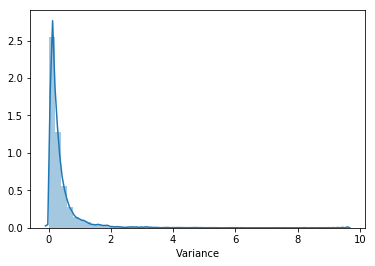

In [28]:
var_df = pd.DataFrame(variance_dict.items(), columns = ['Protein', 'Variance'])
var_df = var_df.dropna()
varplot = sns.distplot(var_df['Variance'])

### Find min, max, and mean variances

In [44]:
variances = list(var_df['Variance'])
min_var = min(variances)
max_var = max(variances)
avg_var = np.mean(variances)

print("MIN: ", min_var)
print("MAX: ", max_var)
print("MEAN: ", avg_var)

MIN:  0.0075381525
MAX:  9.567272110803323
MEAN:  0.37193493622775325


In [45]:
from statsmodels.stats.power import TTestIndPower

In [46]:
analysis = TTestIndPower()

effect_size = analysis.solve_power(nobs1 = 50, power = .8, alpha = .05)

print(effect_size)

0.5658803032224228


In [47]:
# Low, medium, high
variances_low_med_high = [.075, .37, 9.5]
sd = [0.27, 0.61, 3.08]

detectable_diff = []
for standev in sd:
    detectable_diff.append(standev * effect_size)
    
print(detectable_diff)

[0.15278768187005415, 0.3451869849656779, 1.7429113339250621]


In [48]:
print(variances)

[0.34075943433299455, 0.48049778097671647, 1.5386005044173394, 0.5152592239102392, 0.05509122903636611, 0.29609425130915956, 0.3192562878713346, 0.21029103914608804, 0.13616536728962111, 0.08834805155166206, 0.22184422348013236, 0.12428801740185803, 0.06227151943977097, 0.0707222749600813, 0.09273350646392077, 0.1933952229257948, 0.04756001430631442, 0.4632990134686311, 0.11678220727545367, 0.5299769976251997, 0.4742329560372743, 0.42242125614794573, 0.23171403681858038, 0.29240627396812313, 0.3810366236115257, 0.29532258067063444, 0.34047342559503563, 0.29440822199559447, 0.581099769354536, 0.5446911832515605, 0.3743269135550588, 0.8802706239478002, 0.3173183816170707, 0.04412931717262855, 0.05757612286335288, 0.05803808789133401, 0.04176513827785695, 0.5890821354492377, 0.15728295505588616, 0.3324020732558934, 0.39166854497903925, 0.17342058678395794, 0.23113939533607675, 0.24730415392094646, 0.28531352423849066, 0.32103249081712887, 0.20546048360000002, 0.19158782773273508, 0.246675

In [56]:
sorted_variances = sorted(variances)
length = len(sorted_variances)
print(length)
div_ten = length/10

dectiles = []
for i in range(0, 10):
    var_to_add = sorted_variances[int(0+(i*div_ten))]
    #print(var_to_add)
    dectiles.append(var_to_add)
#print(sorted_variances[len(sorted_variances)-1])
dectiles.append(sorted_variances[len(sorted_variances)-1])

print(dectiles)

10993
[0.0075381525, 0.05998126378937438, 0.08672422222222222, 0.1164725950610829, 0.1555542610483089, 0.2052603980007838, 0.26546381541039343, 0.3496826457638889, 0.48915157885543986, 0.7982087384544672, 9.567272110803323]


In [59]:
effect_sizes  = []
for i in range(10, 100, 10):
    analysis = TTestIndPower()

    effect_size = analysis.solve_power(nobs1 = i, power = .8, alpha = .05)

    print(effect_size)
    effect_sizes.append(effect_size)

1.3249473806412124
0.9091290568795594
0.7356198424871614
0.6342985155321065
0.5658803032224228
0.5157065039061857
0.47688182584131383
0.4456842248588056
0.4199048125342994


In [65]:
all_vals = []
for i in range(0,9):
    effect_size_list = []
    for j in range(0,11):
        effect_size_list.append(round(effect_sizes[i]*dectiles[j], 5))
    all_vals.append(effect_size_list)
        
for es in all_vals:
    print(es)

[0.00999, 0.07947, 0.11491, 0.15432, 0.2061, 0.27196, 0.35173, 0.46331, 0.6481, 1.05758, 12.67613]
[0.00685, 0.05453, 0.07884, 0.10589, 0.14142, 0.18661, 0.24134, 0.31791, 0.4447, 0.72567, 8.69789]
[0.00555, 0.04412, 0.0638, 0.08568, 0.11443, 0.15099, 0.19528, 0.25723, 0.35983, 0.58718, 7.03788]
[0.00478, 0.03805, 0.05501, 0.07388, 0.09867, 0.1302, 0.16838, 0.2218, 0.31027, 0.5063, 6.06851]
[0.00427, 0.03394, 0.04908, 0.06591, 0.08803, 0.11615, 0.15022, 0.19788, 0.2768, 0.45169, 5.41393]
[0.00389, 0.03093, 0.04472, 0.06007, 0.08022, 0.10585, 0.1369, 0.18033, 0.25226, 0.41164, 4.9339]
[0.00359, 0.0286, 0.04136, 0.05554, 0.07418, 0.09788, 0.12659, 0.16676, 0.23327, 0.38065, 4.56246]
[0.00336, 0.02673, 0.03865, 0.05191, 0.06933, 0.09148, 0.11831, 0.15585, 0.21801, 0.35575, 4.26398]
[0.00317, 0.02519, 0.03642, 0.04891, 0.06532, 0.08619, 0.11147, 0.14683, 0.2054, 0.33517, 4.01734]
